# Projekt - odovzdanie 3

**Autori:** Patrik Villant, Ivan Vykopal
 
**Cvičenie:** Utorok o 14:00
 
**Cvičiaci:** Ing. Peter Bakonyi
 
**Dátová sada:** 55
 
**Podiel práce:** 50/50

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import datetime
import math
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin/'

In [2]:
class MergeTransformer(TransformerMixin):
    def __init__(self, personal, other, columns=['name', 'address']):
        self.personal = personal
        self.other = other
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data = pd.merge(self.personal, self.other, on=self.columns, how = 'inner')
        return data

In [3]:
class SplittingMedicalTransformer(TransformerMixin):
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for i in range(len(data)):
            row = data.medical_info[i]
            if str(row) == 'nan':
                j ={'mean_glucose': np.nan,
                     'std_glucose': np.nan,
                     'kurtosis_glucose': np.nan,
                     'skewness_glucose': np.nan,
                     'mean_oxygen': np.nan,
                     'std_oxygen': np.nan,
                     'kurtosis_oxygen': np.nan,
                     'skewness_oxygen': np.nan}
            else:
                j = eval(str(row))
            data.at[i,'mean_glucose'] = float(j['mean_glucose'])
            data.at[i,'std_glucose'] = float(j['std_glucose'])
            data.at[i,'kurtosis_glucose'] = float(j['kurtosis_glucose'])
            data.at[i,'skewness_glucose'] = float(j['skewness_glucose'])
            data.at[i,'mean_oxygen'] = float(j['mean_oxygen'])
            data.at[i,'std_oxygen'] = float(j['std_oxygen'])
            data.at[i,'kurtosis_oxygen'] = float(j['kurtosis_oxygen'])
            data.at[i,'skewness_oxygen'] = float(j['skewness_oxygen'])
        data = data.drop(columns=['medical_info'])
        return data

In [4]:
class DeduplicationTransformer(TransformerMixin):
    def __init__(self, columns=['name', 'address']):
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        duplicates = data[data.duplicated(self.columns)]
        unique_names = duplicates.name.unique()
        for i in unique_names: 
            helper = data[data.name == i]
            helper = helper.fillna(method='ffill')
            helper = helper.drop_duplicates(self.columns, keep = 'last')
            data = data.append(helper)
    
        data.drop_duplicates(self.columns, inplace = True, keep = 'last')
        data = data.reset_index(drop = True)
        return data

In [5]:
class StripTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data[self.columns] = data[self.columns].apply(lambda x: x.str.strip())
        return data

In [6]:
class UnificationToNanTransformer(TransformerMixin):
    
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data.replace(to_replace=r'\?+', value=np.nan, regex=True, inplace=True)
        return data

In [7]:
class DateUnificationTransformer(TransformerMixin):
    
    def _unifyFormats(self, data):
        data = data[:10]
        date = re.sub('[0-9]','0', data)
        if date == '0000/00/00':
            data = data.replace('/', '-')
        if date == '00/00/0000':
            data = data[6:] + '-' + data[3:5] +'-' + data[:2]
        if date == '00-00-00':
            if data[0] == 0 or data[0] == 1:
                data = '20' + data[:2] + '-' + data[3:5] + '-' + data[6:]
            else:
                data = '19' + data[:2] + '-' + data[3:5] + '-' + data[6:]
        
        return data
    
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['date_of_birth'] = data['date_of_birth'].apply(self._unifyFormats)
        return data

In [8]:
class AddressUnificationTransformer(TransformerMixin):
    
    def _splittAddress(self, data):
        data['street'] = 'street'
        data['town'] = 'town'
        data['psc'] = 'psc'
        for i in range(len(data.address)):
            helper = re.split('\n|, ', data.address[i])
            data.loc[i, 'street'] = str(helper[0]).strip()
            data.loc[i, 'town'] = str(helper[1])
            if len(helper) == 2:
                data.loc[i, 'town'] = str(helper[1][:-8])
                data.loc[i, 'psc'] = str(helper[1][-8:])
            if len(helper) == 3:
                data.loc[i, 'psc'] = str(helper[2])
        data = data.drop(columns=['address'])
        return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data = self._splittAddress(data)
        return data

In [9]:
class AgeUnificationTransformer(TransformerMixin):
    
    def _unifyAge(self, data):
        date = datetime.date(2019, 12, 31)
        birth = datetime.date(int(data[:4]), int(data[5:7]), int(data[8:]))
        age = date - birth
        age = age.days // 365
        return age
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['age'] = data['date_of_birth'].apply(self._unifyAge)
        return data

In [10]:
class PregnantUnificationTransformer(TransformerMixin):
          
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for i in range(len(data)):
            if data.loc[i, 'pregnant'] in ['f','F','FALSE']:
                data.loc[i, 'pregnant'] = int(0)
            elif data.loc[i, 'pregnant'] in ['t','T','TRUE']:
                data.loc[i, 'pregnant'] = int(1)
            elif data.loc[i, 'sex'] == 'Male':
                data.loc[i, 'pregnant'] = int(0)
            else: 
                data.loc[i, 'pregnant'] = np.nan
        data.pregnant = data.pregnant.astype('int64')
        return data

In [11]:
class WorkclassUnificationTransformer(TransformerMixin):
    def _unifyWorkclass(self, data):
        string = str(data).lower()
        if string == 'nan':
            return np.nan
        else:
            return string
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data.workclass = data.workclass.apply(self._unifyWorkclass)
        return data

In [12]:
class RelationshipUnificationTransformer(TransformerMixin):
    def _unifyRelationship(self, data):
        string = str(data)
        if string == 'nan':
            return np.nan
        else:
            return string.replace('_', '-')
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['relationship'] = data['relationship'].apply(self._unifyRelationship)
        return data

In [13]:
class MedianTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.medians = {}
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.medians[column] = data[column].median()
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.medians[column], inplace=True)
            
        return data

In [14]:
class MeanTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.means = {}
        
    def fit(self, data, y=None):      
        for column in self.columns:
            self.means[column] = data[column].mean()
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.means[column], inplace=True)
            
        return data

In [15]:
class MostFrequentTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.modes = {}
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.modes[column] = data[column].mode()[0]
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.modes[column], inplace=True)
            
        return data

In [16]:
class KNNTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _kNN(self, data, column):
        imp_kNN = KNNImputer(missing_values=np.nan)
        data[column] = imp_kNN.fit_transform(data[[column]])
        return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data = self._kNN(data, column)
            
        return data

In [17]:
class AgeToNanTransformer(TransformerMixin):
        
    def _ageToNan(self, data):
        if data < 0:
            return np.nan
        else:
            return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data['age'] = data['age'].apply(self._ageToNan)   
        return data

Pri triede **ClassRemovalTransformer** prišlo k zmene. Upravili sme túto triedu tak, aby sa po vymazaní záznamov zresetovali indexy záznamov, aby nám v datasete nevznikli diery v rámci indexov záznamov.

In [18]:
class ClassRemovalTransformer(TransformerMixin):
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data = data[data['class'].notna()]
        data = data.reset_index(drop = True)
        return data


In [19]:
class OutliersTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _standarddeviation(self, data):
        data_mean, data_std = np.mean(data), np.std(data)

        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off 

        outliers = [x for x in data if x < lower or x > upper] 
        print('Počet záznamov=', len(data), ', počet outlierov: %d' % len(outliers))
        print('\n')
                
    def _setOutliers(self, data, column):
        percentile_95 = data[column].quantile(0.95)
        percentile_05 = data[column].quantile(0.05)
        data.loc[data[column] < percentile_05, column] = percentile_05
        data.loc[data[column] > percentile_95, column] = percentile_95
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            print('Atribút ', column, '\n')
            print('Pred úpravou:')
            self._standarddeviation(data[column])
            self._setOutliers(data, column)
            print('Po úprave:')
            self._standarddeviation(data[column])
            print('-------------------------------------------------------------------------------------------------------------')

            
        return data

In [20]:
class PowerTransformTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _powerTransform(self, data, column):
        power = PowerTransformer(method='yeo-johnson', standardize=True) 
        data[column] = power.fit_transform(data[[column]])
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            self._powerTransform(data, column)
            
        return data

In [21]:
class HoursUnificationTransformer(TransformerMixin):
        
    def _hoursToNan(self, data):
        if data < 0 or data > 168:
            return np.nan
        else:
            return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data['hours-per-week'] = data['hours-per-week'].apply(self._hoursToNan)   
        return data

Pre **LabelEncoderTransformer** sme upravili to, že v testovacích dátach sa nachádzali aj také hodnoty, ktoré v trénovacích dátach neboli. Na základe týchto zistení sme pre fit metódu, ktorá sa spúšťa na trénovacích dátach vytvorili pre každý atribút kategóriu navyše nazývanú **Unknown**. Do tejto kategórie v rámci atribútu patria tie hodnoty, ktoré sa v trénovacích dátach nevyskytujú, ale v testovacích dátach áno. Takto sme docielili správnosť priraďovania tried aj pre testovacie dáta.

In [22]:
class LabelEncoderTransformer(TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        self.encoders = {}
        for column in self.columns:
            self.encoders[column] = LabelEncoder()
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.encoders[column].fit(list(data[column]) + ['Unknown'])
        return self
    
    def transform(self, data, y=None): 
        for column in self.columns:
            data_list = list(data[column])
            for unique_item in np.unique(data[column]):
                if unique_item not in self.encoders[column].classes_:
                    data_list = ['Unknown' if x==unique_item else x for x in data_list]

            data[column] = self.encoders[column].transform(data_list)
        return data

Po vložení potrebných tried, sme načítali aj trénovacie aj testovacie dáta.

In [23]:
personal_train = pd.read_csv('personal_train.csv', index_col='Unnamed: 0')

In [24]:
other_train = pd.read_csv('other_train.csv', index_col='Unnamed: 0')

In [25]:
personal_valid = pd.read_csv('personal_valid.csv', index_col='Unnamed: 0')

In [26]:
other_valid = pd.read_csv('other_valid.csv', index_col='Unnamed: 0')

Spustili sme pipeline z predspracovania na trénovacích dátach, tak aby sa nám uložili jednotlivé mapovania najmä pre kódovanie hodnôt na numerické.

In [27]:
merge = Pipeline([('merge', MergeTransformer(personal_train, other_train, ['name', 'address']))])

data_train = pd.DataFrame()
data_train = merge.transform(data_train)

In [28]:
most_frequent_missing = ['education-num','race', 'marital-status', 'occupation', 'relationship', 'native-country', 'workclass', 'capital-gain', 'capital-loss']

glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

encode = ['sex', 'race', 'marital-status', 'occupation', 'relationship', 'income', 'native-country', 'workclass', 'town', 'psc', 'street']

outliers = ['fnlwgt', 'mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']

pip = Pipeline([('split_medical', SplittingMedicalTransformer()),
               ('deduplication', DeduplicationTransformer(['name','address'])),
               ('strip', StripTransformer(['sex', 'race', 'marital-status', 'occupation', 'relationship', 'education', 'income', 'native-country', 'workclass'])),
               ('nan_unification', UnificationToNanTransformer()),
               ('date_unification', DateUnificationTransformer()),
               ('address_unification', AddressUnificationTransformer()),
               ('age_unification', AgeUnificationTransformer()),
               ('pregnant_unification', PregnantUnificationTransformer()),
               ('workclass_unification', WorkclassUnificationTransformer()),
               ('relationship_unification', RelationshipUnificationTransformer()),
               ('age_to_nan', AgeToNanTransformer()),
               ('most_frequent_missing', MostFrequentTransformer(most_frequent_missing)),
               ('class_remove', ClassRemovalTransformer()),
               ('hours-per-week', MeanTransformer(['hours-per-week'])),
               ('glucose', KNNTransformer(glucose)),
               ('oxygen_age', MedianTransformer(oxygen_age)),
               ('power_transform',PowerTransformTransformer(outliers)),
               ('outliers', OutliersTransformer(outliers)),
               ('encode', LabelEncoderTransformer(encode))])

pip.fit(data_train)
data_train = pip.transform(data_train)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 22


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 3


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 17


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 18


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  ske

Spojili sme testovacie datasety personal a other do jedného datsetu. Následne na tento dataset sme spustili pipelin z kroku vyššie. Tu sme už využili len metódu predict, keďže cez fit funkciu sa ukladali niektoré hodnoty, ktoré budú využité aj pri testovacích dátach.

In [29]:
merge = Pipeline([('merge', MergeTransformer(personal_valid, other_valid, ['name', 'address']))])

data_valid = pd.DataFrame()
data_valid = merge.transform(data_valid)

In [30]:
data_valid = pip.transform(data_valid)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 2


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 0


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  skewne

In [31]:
data_valid.head()

,name,age,sex,date_of_birth,race,marital-status,occupation,pregnant,education-num,relationship,...,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,street,town,psc
0,Philip Miller,52,1,1967-09-03,5,4,4,0,9.0,1,...,-0.010168,-1.083175,-0.255202,-0.416802,-0.491678,0.332974,0.387414,3922,2226,3520
1,Mitch Wilson,50,0,1969-07-19,5,4,0,0,10.0,3,...,1.065302,-0.959011,-1.406078,0.422036,0.471178,-0.495901,-0.527878,3922,2933,3520
2,James Olsen,36,1,1983-01-20,5,2,13,0,9.0,0,...,-0.281893,-0.503283,-0.059564,-1.386288,-1.454295,1.468397,1.458314,3922,2933,3520
3,Maurice Riley,56,1,1963-04-18,5,2,11,0,4.0,0,...,-0.010168,-0.971483,-0.600971,-0.241584,-0.059667,0.314069,0.286062,3922,810,3520
4,Larry Stanley,72,1,1947-09-04,5,4,9,0,10.0,3,...,-1.670691,1.733144,1.706862,1.609443,1.272269,-1.452033,-1.462614,3922,2933,3520


Po vykonaní pipeline sme si dali vypísať prvých 5 záznamo, kde je možné vidieť, že dáta majú číslené hodnoty, až na atribúty **name**, **date_of_birth** a **education**, ktorý je vlastne mapovaný v education-num.

## Manuálne vytvorenie rozhodovaích pravidiel

### Pre jeden atribút

Zvolený atribút **kurtosis_glucose**

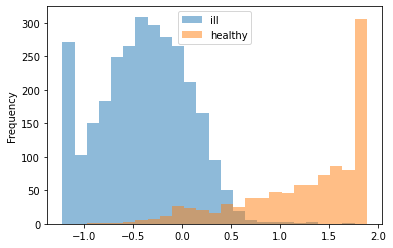

In [32]:
ill_kg = data_train[data_train['class'] == 0.0].kurtosis_glucose
healthy_kg = data_train[data_train['class'] == 1.0].kurtosis_glucose
df = pd.DataFrame({
    'ill': ill_kg,
    'healthy': healthy_kg})
ax = df.plot.hist(bins=25, alpha=0.5)

Na základe histogamu sme si zvolili hodnotu 0.5. Tí pacienti, ktorí budú mať **kurotosis_glucose** pod touto hodnotou budú považovaní za chorých, ostatní budú považovaní za zdravých.

Na základe tohto zistenia sme vytvorili **KurtosisGlucosePredictor**.

In [33]:
class KurtosisGlucosePredictor():
    
    def predict(self, data):
        if data <= 0.5:
            return 0.0
        else:
            return 1.0
    
    def transform(self, data):
        predicted = data['kurtosis_glucose'].apply(self.predict)
        return predicted

Spustili náš prediktor na testovacích dátach.

In [34]:
predicted_valid = KurtosisGlucosePredictor().transform(data_valid)

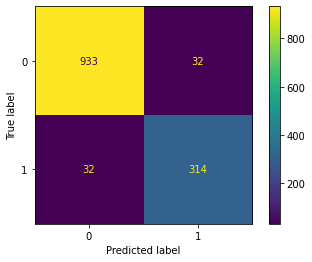

In [35]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [36]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       965
         1.0       0.91      0.91      0.91       346

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [37]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9511823035850496


Na základe vypísaných metrík, správnosť vychádza na hodnotu približne 0.951, t.j 95.1%. Boli vypísané aj metriky ako presnosť, úplnosť a f1-score.

### Pre päť atribútov

Zvolené atribúty **kurtosis_glucose**, **mean_glucose**, **mean_oxygen**, **kurtosis_oxygen**, **skewness_glucose**.

Histogram pre **kurtosis_glucose** je vytvorený už pri predchádzajúcom prediktore (klasifikátore). V tejto časti sme zobrazili histogramy pre **mean_glucose**, **mean_oxygen**, **kurtosis_oxygen** a **skewness_glucose**. Boli vybraté na základe závislostí, ktoré boli odhalené pri predspracovaní.

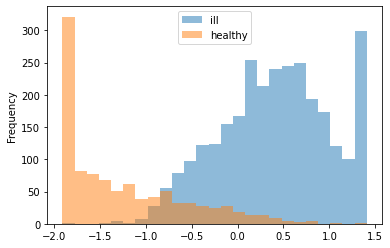

In [38]:
ill_mg = data_train[data_train['class'] == 0.0].mean_glucose
healthy_mg = data_train[data_train['class'] == 1.0].mean_glucose
df = pd.DataFrame({
    'ill': ill_mg,
    'healthy': healthy_mg})
ax = df.plot.hist(bins=25, alpha=0.5)

Pre atribút **mean_glucose** sme vybrali porovnávaciu hodnotu -0.7 na základe histogramu. Pre hodnotu atribútu menšiu ako je hodnota -0.7 sú pacienti pravdepodobne zdraví, inak sú chorí, na základe daného atribútu.

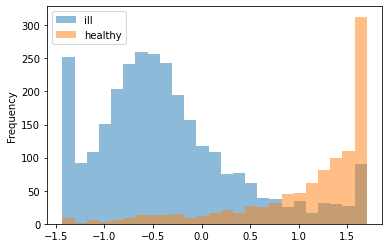

In [39]:
ill_mo = data_train[data_train['class'] == 0.0].mean_oxygen
healthy_mo = data_train[data_train['class'] == 1.0].mean_oxygen
df = pd.DataFrame({
    'ill': ill_mo,
    'healthy': healthy_mo})
ax = df.plot.hist(bins=25, alpha=0.5)

Pre atribút **mean_oxygen** sme vybrali porovnávaciu hodnotu 0.7 na základe histogramu. Pre hodnotu atribútu väčšiu ako je hodnota 0.7 sú pacienti pravdepodobne zdraví, inak sú chorí, na základe daného atribútu.

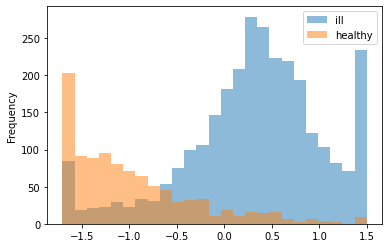

In [40]:
ill_ko = data_train[data_train['class'] == 0.0].kurtosis_oxygen
healthy_ko = data_train[data_train['class'] == 1.0].kurtosis_oxygen
df = pd.DataFrame({
    'ill': ill_ko,
    'healthy': healthy_ko})
ax = df.plot.hist(bins=25, alpha=0.5)

Pre atribút **kurtotisi_oxygen** sme vybrali porovnávaciu hodnotu -0.6 na základe histogramu. Pre hodnotu atribútu väčšiu ako je hodnota -0.6 sú pacienti pravdepodobne chorí, inak sú zdraví na základe daného atribútu.

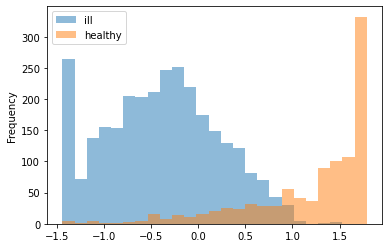

In [41]:
ill_sg = data_train[data_train['class'] == 0.0].skewness_glucose
healthy_sg = data_train[data_train['class'] == 1.0].skewness_glucose
df = pd.DataFrame({
    'ill': ill_sg,
    'healthy': healthy_sg})
ax = df.plot.hist(bins=25, alpha=0.5)

Pre atribút **skewness_glucose** sme vybrali porovnávaciu hodnotu 0.8 na základe histogramu. Pre hodnotu atribútu väčšiu ako je hodnota 0.8 sú pacienti pravdepodobne zdraví, inak sú chorí.

Na základe piatich vyššie spomínaných atribútoch sme vytvorili prediktor (klasifikátor), ktorí berie do úvahy päť atribútov. Riešili sme to tak, že v prípade, ak minimálne 3 z 5 atribútov podľa nami zvolených hodnôt vyhodnotia pacienta za chorého, tak pacient je chorý. V prípade, ak len dva atribúty z 5 vyhodnotí pacienta za chorého, tak pacient je pravdepodobne zdraví.

In [42]:
class ComplexPredictor():
    
    def predict(self, row):
        
        if row.kurtosis_glucose <= 0.5:#chorý
            if row.mean_glucose <= -0.7:#zdravý
                if row.mean_oxygen <= 0.7:#chorý
                    if row.kurtosis_oxygen <= -0.6:#zdravý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 1.0
                    else:#chorý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 0.0
                        
                else:#zdravý
                    if row.kurtosis_oxygen <= -0.6:#zdravý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 1.0
                        else:#zdravý
                            return 1.0
                    else:#chorý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 1.0
        
            else:#chorý
                if row.mean_oxygen <= 0.7:#chorý
                    if row.kurtosis_oxygen <= -0.6:#zdravý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 0.0
                    else:#chorý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 0.0
                        
                else:#zdravý
                    if row.kurtosis_oxygen <= -0.6:#zdravý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 1.0
                    else:#chorý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 0.0 

        else:#zdravý
            if row.mean_glucose <= -0.7:#zdravý
                if row.mean_oxygen <= 0.7:#chorý
                    if row.kurtosis_oxygen <= -0.6:#zdravý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 1.0
                        else:#zdravý
                            return 1.0
                    else:#chorý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 1.0
                        
                else:#zdravý
                    if row.kurtosis_oxygen <= -0.6:#zdravý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 1.0
                        else:#zdravý
                            return 1.0
                    else:#chorý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 1.0
                        else:#zdravý
                            return 1.0
                          
            else:#chorý
                if row.mean_oxygen <= 0.7:#chorý
                    if row.kurtosis_oxygen <= -0.6:#zdravý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 1.0
                    else:#chorý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 0.0
                        
                else:#zdravý
                    if row.kurtosis_oxygen <= -0.6:#zdravý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 1.0
                        else:#zdravý
                            return 1.0
                    else:#chorý
                        if row.skewness_glucose <= 0.8:#chorý
                            return 0.0
                        else:#zdravý
                            return 1.0
            
    
    def transform(self, data):
        predicted = []
        for i in range(len(data)):
            predicted.append(self.predict(data.loc[i]))
            
        return pd.Series(predicted)

![alt text](./our-tree.svg)

Spustili nami vytvorený prediktor na testovcích dátach.

In [43]:
predicted_valid = ComplexPredictor().transform(data_valid)

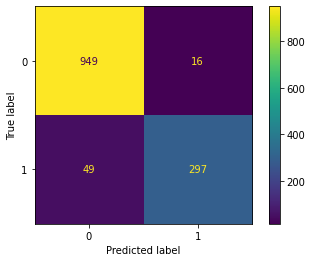

In [44]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [45]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       965
         1.0       0.95      0.86      0.90       346

    accuracy                           0.95      1311
   macro avg       0.95      0.92      0.93      1311
weighted avg       0.95      0.95      0.95      1311



In [46]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.950419527078566


Na základe vypísaných metrík, správnosť vychádza približne 0.95, t.j 95%. Boli vypísané aj metriky ako presnosť, úplnosť a f1-score. Rozdiel medzi klasifikátorom s jedným atribútom a s 5 atribútmi je 0.07%. Lepšiu správnosť má nami vytvorený klasifikátor len s jedným atribútom.

## Využitie DecisionTree z scikit-learn

Využili sme DecisionTreeClassifier z knižnice scikit-learn. Kde sme si zvolili maximálnu hĺbku stromu 6.

In [47]:
data_copy = data_train.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_train['class']

clf = tree.DecisionTreeClassifier(max_depth = 6)
clf = clf.fit(X, y)

Vytvorili sme vizualizáciu pre DecisionTreeClasifier, ktorý sme využili vyššie. Oranžová farba predstavuje tie vrcholy, kde pre tento vrchol je pacient chorý a pre modrý vrchol je pacient zdravý.

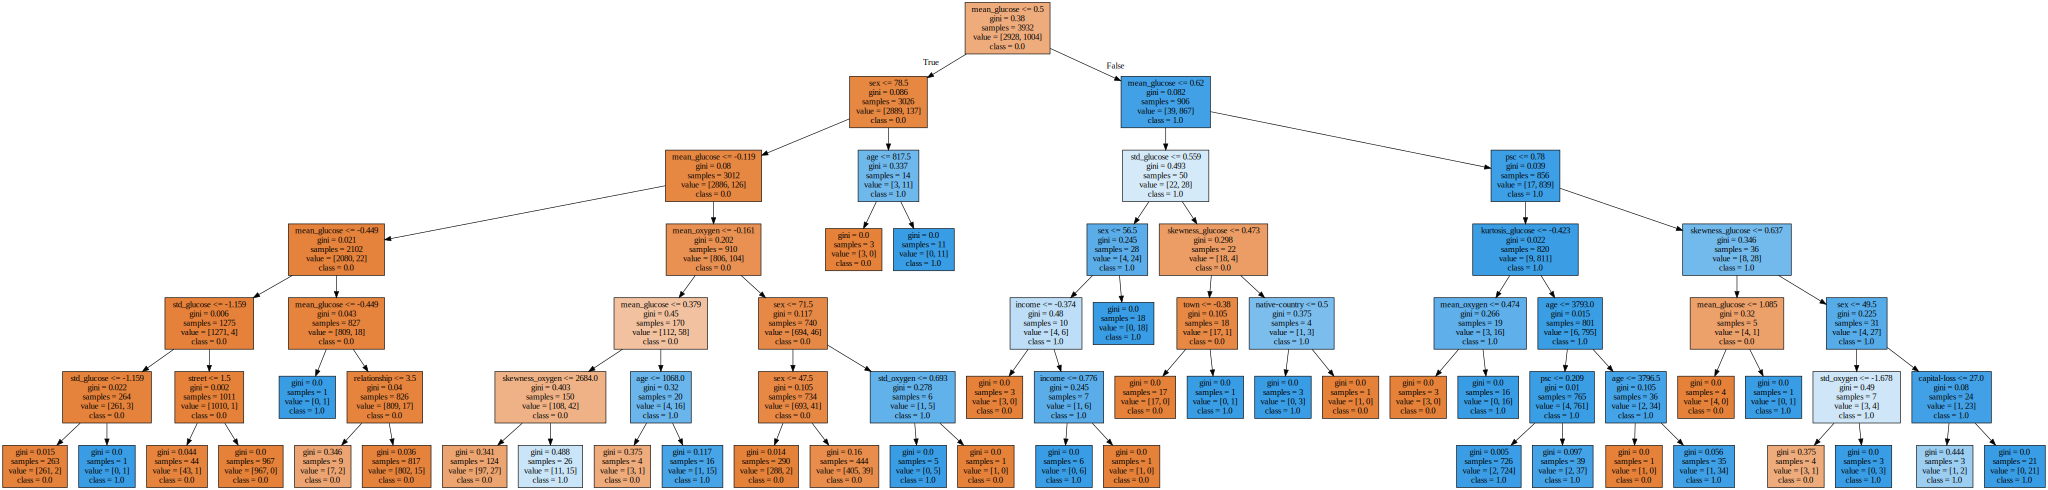

In [48]:
glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

columns = ['sex', 'race', 'marital-status', 'occupation', 'pregnant', 'education-num', 'relationship', 'capital-gain', 'fnlwgt', 'income', 'native-country', 'hours-per-week', 'capital-loss', 'workclass', 'street', 'town', 'psc'] + glucose + oxygen_age

# generovanie grafu pre obrázok
export_graphviz(clf, out_file='dectree1.dot', feature_names=columns, class_names=['0.0', '1.0'], filled = True)

graph = Source(export_graphviz(clf, 
                               out_file=None,
                               feature_names=columns,
                               class_names=['0.0', '1.0'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
HTML(style)

![alt text](./dectree1.png)

Následne vytvorený strom sme spustili na testovacích dátach.

In [49]:
data_copy = data_valid.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_valid['class']

predicted_valid = clf.predict(X)

In [50]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       965
         1.0       0.87      0.95      0.90       346

    accuracy                           0.95      1311
   macro avg       0.92      0.95      0.93      1311
weighted avg       0.95      0.95      0.95      1311



In [51]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9473684210526315


Správnosť stromu na testovacích dátach je 94.7%.

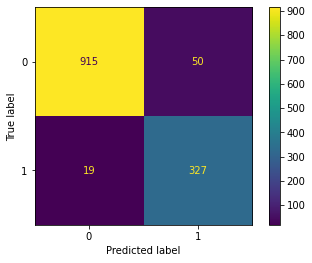

In [52]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

### Random Forest

Na otestovanie viacerých možností sme využili aj RandomForestClassifier zo scikir-learn. Pri tomto klasifikátore sme zvolili maximálnu hĺbku 3 a random_state 1.

In [53]:
data_copy = data_train.drop(columns=['class', 'name', 'date_of_birth', 'education'])

In [54]:
data_copy_v = data_valid.drop(columns=['class', 'name', 'date_of_birth', 'education'])

In [55]:
forest = RandomForestClassifier(random_state=1,max_depth=3)
model = forest.fit(data_copy, data_train['class'])

Spustenie RandomForestClassifier na testovacích dátach.

In [56]:
y_pred_valid = model.predict(data_copy_v)

In [57]:
print(classification_report(data_valid['class'], y_pred_valid))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       965
         1.0       0.96      0.86      0.91       346

    accuracy                           0.95      1311
   macro avg       0.95      0.92      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [58]:
print(accuracy_score(data_valid['class'], y_pred_valid))

0.9527078565980168


Správnosť na testovacích dátach má hodnotu približne 95.3%. Zobrazili sme aj Confusion Matrix.

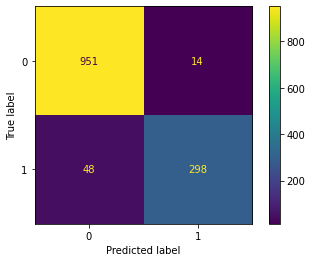

In [59]:
cm = confusion_matrix(data_valid['class'], y_pred_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

## Porovnanie našich klasifikátorov a stromových klasifikátorov

Nami vytvorený klasifikátor, ktorý využíva len jeden atribút má správnosť na testovacích dátach odnotu 0.9511823035850496.

Klasifikátor, ktorý využíva 5 atribútov na testovacích dátach preukázal správnosť 0.950419527078566. 

DecisionTreeClssifier zo scikit-learn má správnosť na testovacích dátach 0.9473684210526315.

RandomForestClassifier má správnosť 0.9527078565980168.

Na základe týchto hodnôt vieme povedať, že správnosť je približne na všetkých klasifikátoroch rovnaká a rozdiel nie je veľmi veľký. Najväčší rozdiel je medzi DecisionTreeClasifier a RandomForestClassifier a ten rozdiel je 0.5%. ALe v porovnaní s našími klasifikátormi rozdieli nie sú veľké.

Zo 4 vymenovaných klasifikátorov sa avšak najlepšie ukazuje na testovacích dátach RandomForestClassifier.

## Hyperparameter tuning

Pre DecisionTreeClassfier vykonáme hyperparameter tuning. Kde využijeme GridSearchCV na testovanie viacerých parametrov pre strom.

Vytvorili sme rozhodovací strom, kde sme strom natrénovali na trénovacích dátach a hneď vyhodnotili na testovacích avšak bez metrík. Tento vytvorený strom budeme následne rozoberať na základe viacerých parametrov.

In [60]:
tcf = tree.DecisionTreeClassifier()
model = tcf.fit(data_copy, data_train['class'])
y_pred = model.predict(data_copy_v)

Pre DecisionTreeClassifier sme si zvolili 5 parametrov.
Parametre:
- **criterion** - funkcia na základe ktorej sa vypočítava kvalita rozdelenia, vybrali sme hodnoty gini a entropy
- **max_depth** - predstavuje maximálnu hĺbku stromu, tieto hodnoty sme zvolili z rozsahu 1 až 15
- **min_samples_split** - vyjadruje minimálny počet vzoriek na rozdelenie vrcholu, vybrali sme rozsah tiež 1 až 15
- **min_samples_leaf** - vyjadruje minimálny počet vzoriek potrebných v listoch stromu, vybrali sme rozsah 1 až 10
- **max_features** - vyjadruje maximálny počet atribútov (vlastností), pre ktoré bude zohľadňovať rozdelenie vnútorného vrcholu, vybrali sme rozsah 1 až 10 atribútov

Následne sme spustili GridSearchCV s danými hyperparametrami a s 10 násobnou krížovou validáciou (cv=10).

In [61]:
criterion = ['gini', 'entropy']
max_depth = range(1,15)
min_samples_split = range(1,15)
min_samples_leaf = range(1,10) 
max_features = range(1,10)

hyper = dict(criterion = criterion,
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf,
             max_features = max_features
            )
gs = GridSearchCV(tcf, param_grid=hyper, cv=10, verbose=1, n_jobs=-1)

best = gs.fit(data_copy, data_train['class'])

Fitting 10 folds for each of 31752 candidates, totalling 317520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 11280 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 18480 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 27280 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 37680 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 49680 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 63280 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 78480 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 95280 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 113680 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 133680 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 155280 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1

Po vykonaní GridSearchCV sme vypísali klasifikátor spolu s najlepšími paramterami. Tento klasifikátor sme následne spustili aj na trénovacích aj testovacích dátach.

In [62]:
gs.best_estimator_

DecisionTreeClassifier(max_depth=6, max_features=8, min_samples_split=8)

Ako najlepšie parametre nám vyšli:
- **max_depth** s hodnotou 6,
- **max_features** s hodnotou 8,
- **min_samples_split** s hodnotou 8.

In [63]:
clf = tree.DecisionTreeClassifier(max_depth=6, max_features=8, min_samples_split=8)
clf = clf.fit(data_copy, data_train['class'])

Následne sme zobrazili grafický vizuál rozhodovacieho stromu.

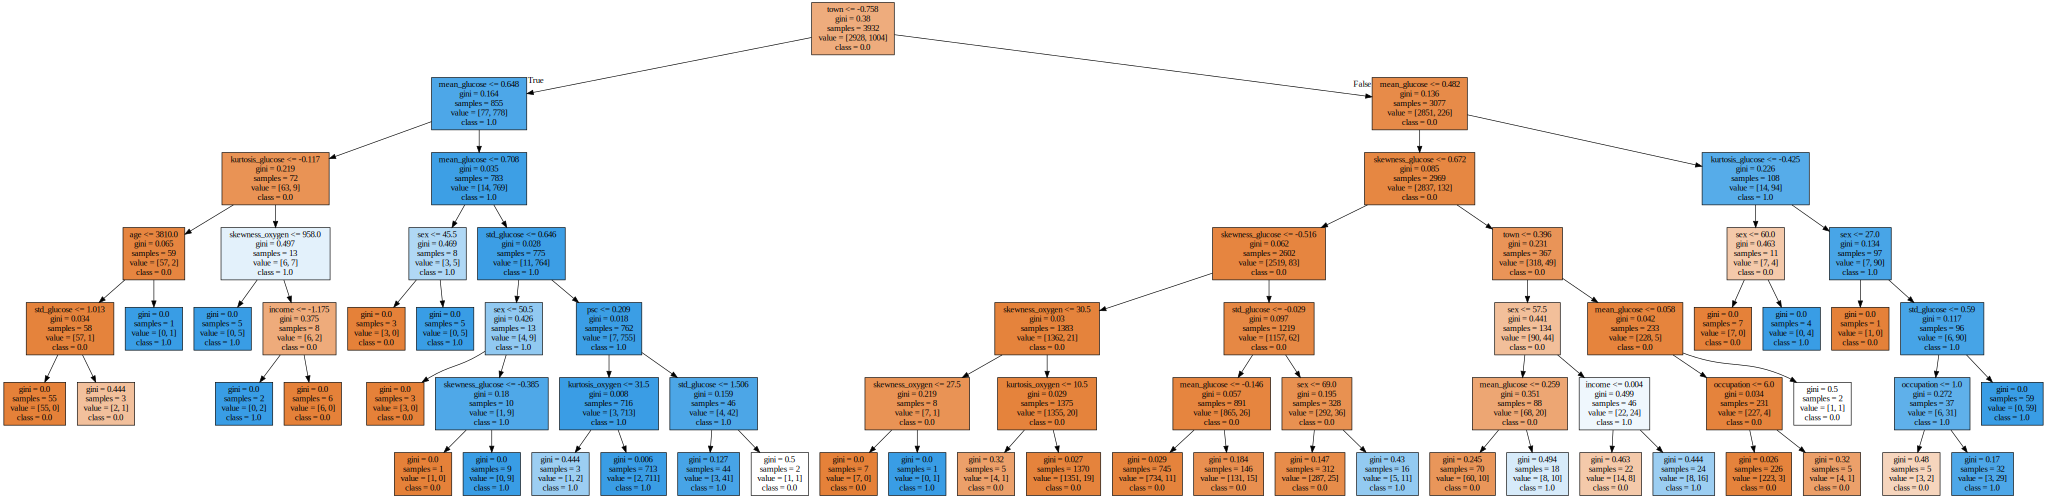

In [64]:
# generovanie grafu pre obrázok
export_graphviz(clf, out_file='dectree2.dot', feature_names=columns, class_names=['0.0', '1.0'], filled = True)

graph = Source(export_graphviz(clf, 
                               out_file=None,
                               feature_names=columns,
                               class_names=['0.0', '1.0'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
HTML(style)

![alt text](./dectree2.png)

In [65]:
predicted_valid = clf.predict(data_copy_v)

In [66]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       965
         1.0       0.93      0.91      0.92       346

    accuracy                           0.96      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.96      0.96      0.96      1311



In [67]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9572845156369184


Správnosť rozhodovacieho stromu na testovacích dátach je 95,7%. Zobrazili sme aj Confusion Matrix, kde vieme nájsť koľko hodnôt bolo predikovaných správne a koľko ich bolo predikovaných nesprávne pre jednotlivé kategórie.

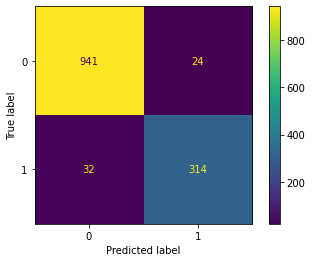

In [68]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

## Vyhodnotenie vplyvu zvolenej stratégie nahrádzania chýbajúcich hodnôt na správnosť klasifikácie

Na to, aby sme zistili, či iný spôsob nahrádzanie chýbajúcich hodnôt má vplyv na správnosť klasifikácie je potrebné otestovať aj iné spôsoby nahrádzania hodnôt.

### Nahradenie chýbajúcich hodnôt pre číslené atribúty pomocou priemeru

Ako prvé sme si zvolili spôsob, že všetky číslené atribúty sme nahradili priemernými hodnotami daného atribútu.

Načítali sme opäť datasety, nad ktorými sme spustili pipeliny.

In [69]:
personal_train = pd.read_csv('personal_train.csv', index_col='Unnamed: 0')

In [70]:
other_train = pd.read_csv('other_train.csv', index_col='Unnamed: 0')

In [71]:
personal_valid = pd.read_csv('personal_valid.csv', index_col='Unnamed: 0')

In [72]:
other_valid = pd.read_csv('other_valid.csv', index_col='Unnamed: 0')

In [73]:
merge = Pipeline([('merge', MergeTransformer(personal_train, other_train, ['name', 'address']))])

data_train = pd.DataFrame()
data_train = merge.transform(data_train)

Chýbajúce hodnoty pre číslené atribúty sme nahradili priemerom.

In [74]:
most_frequent_missing = ['education-num','race', 'marital-status', 'occupation', 'relationship', 'native-country', 'workclass', 'capital-gain', 'capital-loss']

glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

encode = ['sex', 'race', 'marital-status', 'occupation', 'relationship', 'income', 'native-country', 'workclass', 'town', 'psc', 'street']

outliers = ['fnlwgt', 'mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']

pip = Pipeline([('split_medical', SplittingMedicalTransformer()),
               ('deduplication', DeduplicationTransformer(['name','address'])),
               ('strip', StripTransformer(['sex', 'race', 'marital-status', 'occupation', 'relationship', 'education', 'income', 'native-country', 'workclass'])),
               ('nan_unification', UnificationToNanTransformer()),
               ('date_unification', DateUnificationTransformer()),
               ('address_unification', AddressUnificationTransformer()),
               ('age_unification', AgeUnificationTransformer()),
               ('pregnant_unification', PregnantUnificationTransformer()),
               ('workclass_unification', WorkclassUnificationTransformer()),
               ('relationship_unification', RelationshipUnificationTransformer()),
               ('age_to_nan', AgeToNanTransformer()),
               ('most_frequent_missing', MostFrequentTransformer(most_frequent_missing)),
               ('class_remove', ClassRemovalTransformer()),
               ('hours-per-week', MeanTransformer(['hours-per-week'])),
               ('glucose', MeanTransformer(glucose)),
               ('oxygen_age', MeanTransformer(oxygen_age)),
               ('power_transform',PowerTransformTransformer(outliers)),
               ('outliers', OutliersTransformer(outliers)),
               ('encode', LabelEncoderTransformer(encode))])

pip.fit(data_train)
data_train = pip.transform(data_train)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 22


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 3


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 17


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 18


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  ske

In [75]:
merge = Pipeline([('merge', MergeTransformer(personal_valid, other_valid, ['name', 'address']))])

data_valid = pd.DataFrame()
data_valid = merge.transform(data_valid)

In [76]:
data_valid = pip.transform(data_valid)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 2


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 0


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  skewne

#### Testovanie DecisionTree

Nami zadefinovaný rozhodovací strom s maximálnou hĺbkou 6, sme otestovali na dátach, kde chýbajúce hodnoty boli nahradené iným spôsobom. Konrkétne nahradenie priemerom pre číselné atribúty.

In [77]:
data_copy = data_train.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_train['class']

clf = tree.DecisionTreeClassifier(max_depth = 6)
clf = clf.fit(X, y)

Dali sme zobraziť aj grafické reprezentáciu rozhodovacieho stromu.

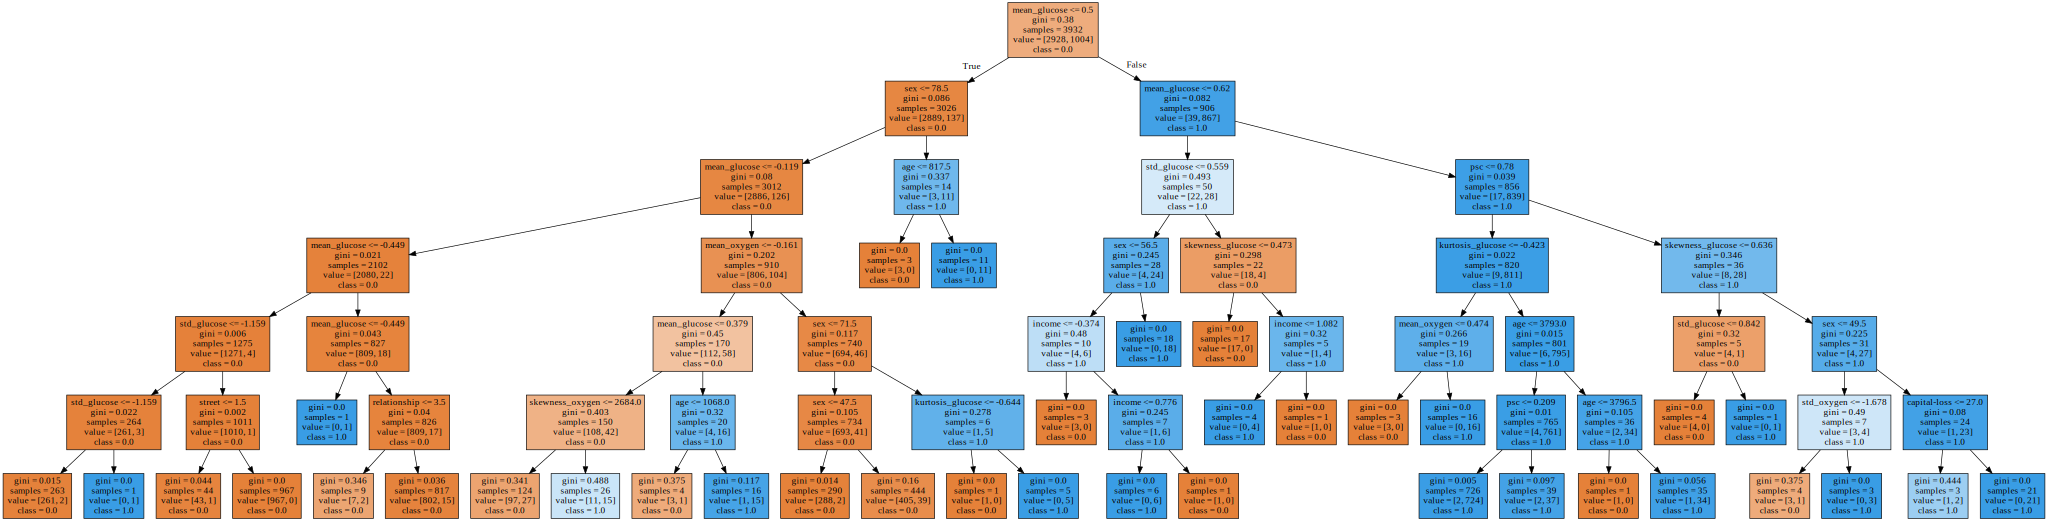

In [78]:
glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

columns = ['sex', 'race', 'marital-status', 'occupation', 'pregnant', 'education-num', 'relationship', 'capital-gain', 'fnlwgt', 'income', 'native-country', 'hours-per-week', 'capital-loss', 'workclass', 'street', 'town', 'psc'] + glucose + oxygen_age

# generovanie grafu pre obrázok
export_graphviz(clf, out_file='dectree3.dot', feature_names=columns, class_names=['0.0', '1.0'], filled = True)

graph = Source(export_graphviz(clf, 
                               out_file=None,
                               feature_names=columns,
                               class_names=['0.0', '1.0'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
HTML(style)

![alt text](./dectree3.png)

In [79]:
data_copy = data_valid.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_valid['class']

predicted_valid = clf.predict(X) 

In [80]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       965
         1.0       0.87      0.95      0.91       346

    accuracy                           0.95      1311
   macro avg       0.93      0.95      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [81]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9488939740655988


Prvý spôsob: 0.9473684210526315

Nahradenie cez priemer: 0.9488939740655988

V tomto prípade vidíme zvýšenie približne len o 0.0015, respektíve o 0.15%.

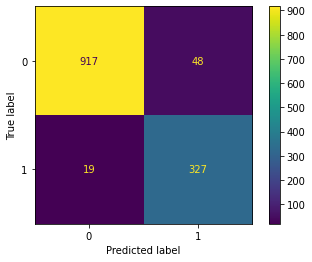

In [82]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

### Nahradenie chýbajúcich hodnôt pre číslené atribúty cez K najbližších susedov

Pre lepšie otestovanie sa pokúsime chýbajúce hodnoty číselných atribútov nahradiť priemerom K najbližších susedov.

In [83]:
merge = Pipeline([('merge', MergeTransformer(personal_train, other_train, ['name', 'address']))])

data_train = pd.DataFrame()
data_train = merge.transform(data_train)

In [84]:
most_frequent_missing = ['education-num','race', 'marital-status', 'occupation', 'relationship', 'native-country', 'workclass', 'capital-gain', 'capital-loss']

glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

encode = ['sex', 'race', 'marital-status', 'occupation', 'relationship', 'income', 'native-country', 'workclass', 'town', 'psc', 'street']

outliers = ['fnlwgt', 'mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']

pip = Pipeline([('split_medical', SplittingMedicalTransformer()),
               ('deduplication', DeduplicationTransformer(['name','address'])),
               ('strip', StripTransformer(['sex', 'race', 'marital-status', 'occupation', 'relationship', 'education', 'income', 'native-country', 'workclass'])),
               ('nan_unification', UnificationToNanTransformer()),
               ('date_unification', DateUnificationTransformer()),
               ('address_unification', AddressUnificationTransformer()),
               ('age_unification', AgeUnificationTransformer()),
               ('pregnant_unification', PregnantUnificationTransformer()),
               ('workclass_unification', WorkclassUnificationTransformer()),
               ('relationship_unification', RelationshipUnificationTransformer()),
               ('age_to_nan', AgeToNanTransformer()),
               ('most_frequent_missing', MostFrequentTransformer(most_frequent_missing)),
               ('class_remove', ClassRemovalTransformer()),
               ('hours-per-week', KNNTransformer(['hours-per-week'])),
               ('glucose', KNNTransformer(glucose)),
               ('oxygen_age', KNNTransformer(oxygen_age)),
               ('power_transform',PowerTransformTransformer(outliers)),
               ('outliers', OutliersTransformer(outliers)),
               ('encode', LabelEncoderTransformer(encode))])

pip.fit(data_train)
data_train = pip.transform(data_train)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 22


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 3


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 17


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 18


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  ske

In [85]:
merge = Pipeline([('merge', MergeTransformer(personal_valid, other_valid, ['name', 'address']))])

data_valid = pd.DataFrame()
data_valid = merge.transform(data_valid)

In [86]:
data_valid = pip.transform(data_valid)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 2


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 0


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  skewne

In [87]:
data_copy = data_train.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_train['class']

clf = tree.DecisionTreeClassifier(max_depth = 6)
clf = clf.fit(X, y)

Grafické znázornenie vytvoreného rozhodovacieho stromu

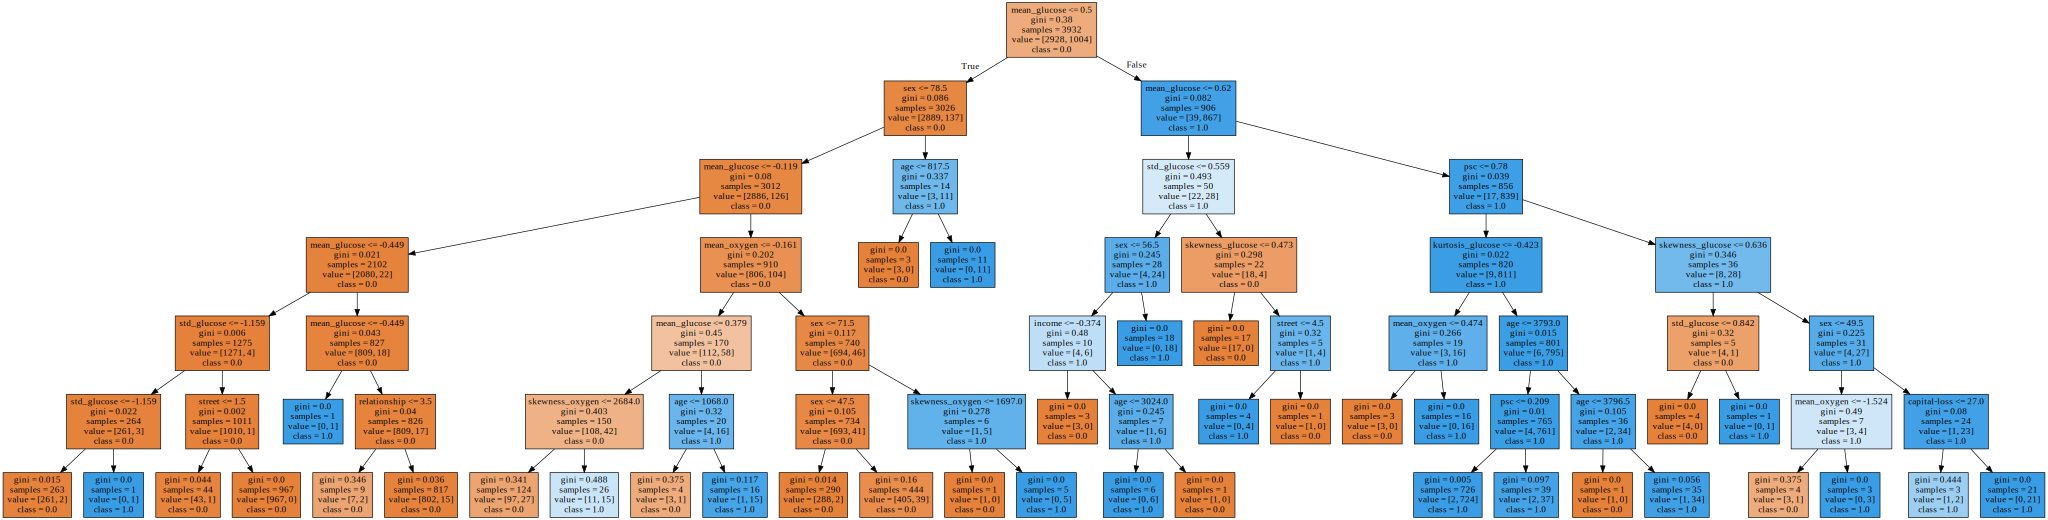

In [88]:
glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

columns = ['sex', 'race', 'marital-status', 'occupation', 'pregnant', 'education-num', 'relationship', 'capital-gain', 'fnlwgt', 'income', 'native-country', 'hours-per-week', 'capital-loss', 'workclass', 'street', 'town', 'psc'] + glucose + oxygen_age

# generovanie grafu pre obrázok
export_graphviz(clf, out_file='dectree4.dot', feature_names=columns, class_names=['0.0', '1.0'], filled = True)

graph = Source(export_graphviz(clf, 
                               out_file=None,
                               feature_names=columns,
                               class_names=['0.0', '1.0'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
HTML(style)

![alt text](./dectree4.png)

In [89]:
data_copy = data_valid.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_valid['class']

predicted_valid = clf.predict(X)

In [90]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       965
         1.0       0.87      0.93      0.90       346

    accuracy                           0.94      1311
   macro avg       0.92      0.94      0.93      1311
weighted avg       0.95      0.94      0.94      1311



In [91]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9443173150266971


V prvom prípade nahrádzania chýbajúcich hodnôt mala správnosť hodnotu 0.9473684210526315.

Pri nahrádzaní chýbajúcich hodnôt prostredníctvom K najbližších susedov má správnosť hodnotu 0.9443173150266971.

Rozdiel správnosti rôznych spôsobov je približne 0.3% s tým, že nahradenie chýbajúcich hodnôt číselných atribútov prostredníctvom k najbližších susedov má horší výsledok.

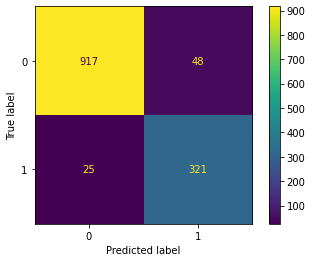

In [92]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

## Záver

V rámci porovnania viacerých spôsobov nahrádzania chýbajúcich hodnôt vyšli lepšie výsledky pre nahradenie pomocou priemeru. Na testovacích dátach vykázali lepšiu správnosť o približne 0.15% oproti pôvodnému rozhodovaciemu stromu. Avšak vplyv spôsobu nahrádzania hodnôt v našom prípade bol veľmi minimálny ani nie celé 1%.